<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/05.trees/05.trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from collections import Counter

from imblearn.over_sampling import SMOTE


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat, plot_feature_importances


!pip install ipython-autotime # To show time at each cell
                              # Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
%load_ext autotime

--2020-03-24 07:49:38--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5159 (5.0K) [text/plain]
Saving to: ‘visualization.py.1’

visualization.py.1  100%[===================>]   5.04K  --.-KB/s    in 0s      

2020-03-24 07:49:39 (76.8 MB/s) - ‘visualization.py.1’ saved [5159/5159]

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=641dfc0c56498c5b2e5229718ef652386d014fea7239c4447d4a8483b1a2f634
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Use case and dataset

We use the dataset by [Reyhane Askari Hemmat](https://github.com/ReyhaneAskari/SLA_violation_classification) (Université de Montréal) used in [He16]. This dataset is built from [Google Cloud Cluster Trace](https://github.com/google/cluster-data), a 29-days trace of activity in a Google Cloud cluster. The trace reports:

* Resources available on the machines
* Tasks submitted by users, along with the requested resources
* Actual resources used by tasks
* Events, like eviction of tasks (for lack of resources, failure of the machine, etc.)


Hemmat et Al. [He16] pre-processed this trace:
* For each submitted task, they checked if the task correctly terminates or is evicted
* They created as csv file with the task characteristics and a `violation` column, to indicating failure (1) or normal termination (0).


### Goal
Predict a task failure, i.e., whether a task [will be evicted](https://github.com/ReyhaneAskari/SLA_violation_classification/blob/55bba2683dec43e739244b6b616294827a98f8e1/3_create_database/scripts/full_db_2.py#L33) before normal termination. 

In [2]:
!wget https://raw.githubusercontent.com/ReyhaneAskari/SLA_violation_classification/master/3_create_database/csvs/frull_db_2.csv

--2020-03-24 07:26:53--  https://raw.githubusercontent.com/ReyhaneAskari/SLA_violation_classification/master/3_create_database/csvs/frull_db_2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10633997 (10M) [text/plain]
Saving to: ‘frull_db_2.csv’

frull_db_2.csv      100%[===================>]  10.14M  26.6MB/s    in 0.4s    

2020-03-24 07:26:54 (26.6 MB/s) - ‘frull_db_2.csv’ saved [10633997/10633997]



Unfortunately, [no GPU support](https://stackoverflow.com/a/41568439/2110769) is available for scikit learn.

# Load dataset and preliminary operations


In [3]:
train_path = "frull_db_2.csv"
df = pd.read_csv(train_path)
df

,Unnamed: 0,job_id,task_idx,sched_cls,priority,cpu_requested,mem_requested,disk,violation
0,2,3418314,0,3,9,0.12500,0.074460,0.000424,0
1,3,3418314,1,3,9,0.12500,0.074460,0.000424,0
2,45,3418368,0,3,9,0.03125,0.086910,0.000455,0
3,46,3418368,1,3,9,0.03125,0.086910,0.000455,0
4,47,3418368,2,3,9,0.03125,0.086910,0.000455,0
...,...,...,...,...,...,...,...,...,...
201195,450131,6251995937,196,0,0,0.06873,0.011930,0.000115,0
201196,450134,4392480606,180,2,0,0.06250,0.063350,0.000077,0
201197,450137,5285926325,0,0,9,0.06250,0.006218,0.000038,1
201198,450142,6183750753,60,1,0,0.12500,0.033390,0.000019,0


Column description:
* `job_id`: users submit jobs, i.e., a set of tasks
* `task_idx`: the index of a task within a job. A task is uniquely identified by `(job_id, task_idx)`
* `sched_cls`: From [Re11]: "3 representing a more latency-sensitive task (e.g., serving revenue-generating user requests) and 0 representing a non-production task (e.g., development, non-business-critical analyses, etc.)... more latency-sensitive tasks tend to have higher task priorities"
* `priority`
* `cpu_requested`: Maximum amount of CPU the task is permitted to use. 
  * Unit of measurement: core-count / second.
  * The scale is relateive to the CPU available in the most powerful machine of the cluster.
  * This is specified by the user at submission time
* `mem_requested`: Maximum amount of memory the task is permitted to use. 
  * Unit of measurement: GB
  * The scale is relateive to the memory available in the machine of the cluster with the largest memory.
  * This is specified by the user at submission time
* `disk`: Similarly to `mem_requested`

We need to remove features that have no predictive meaning

In [4]:
df = df.drop(labels=['Unnamed: 0', 'job_id', 'task_idx'], axis=1)
df

,sched_cls,priority,cpu_requested,mem_requested,disk,violation
0,3,9,0.12500,0.074460,0.000424,0
1,3,9,0.12500,0.074460,0.000424,0
2,3,9,0.03125,0.086910,0.000455,0
3,3,9,0.03125,0.086910,0.000455,0
4,3,9,0.03125,0.086910,0.000455,0
...,...,...,...,...,...,...
201195,0,0,0.06873,0.011930,0.000115,0
201196,2,0,0.06250,0.063350,0.000077,0
201197,0,9,0.06250,0.006218,0.000038,1
201198,1,0,0.12500,0.033390,0.000019,0


Let's partition the dataset in training and test dataset

In [0]:
X = df.drop(labels='violation', axis=1)
y = df['violation']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                        shuffle=True, random_state=4)

Check for class imbalance and correct for it

In [6]:
print( "Samples per class before SMOTE: ", Counter(y_train) )

smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

print( "Samples per class after SMOTE: ", Counter(y_train) )

Samples per class before SMOTE:  Counter({0: 129445, 1: 11395})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Samples per class after SMOTE:  Counter({0: 129445, 1: 129445})


# Training and testing a random forest

In [7]:
model = RandomForestClassifier(n_estimators=100, 
                      criterion='gini', 
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=5, verbose=0,
                       warm_start=False)

Normalized confusion matrix
[[0.90172703 0.09827297]
 [0.11095011 0.88904989]]


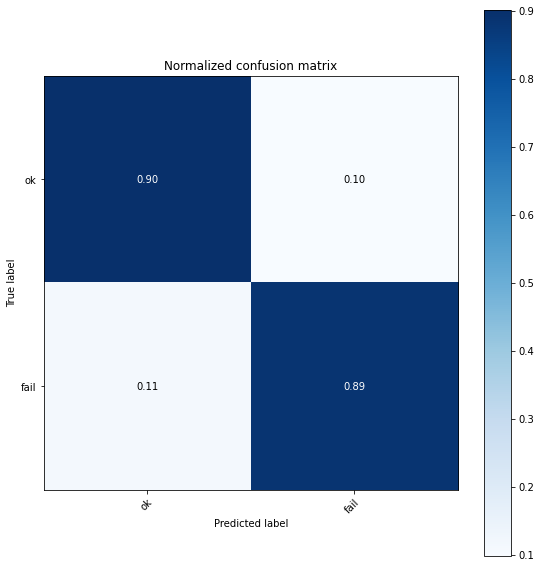

In [8]:
y_pred = model.predict(X_test)

class_names = np.array(['ok', 'fail'])
plot_conf_mat(y_test, y_pred, class_names)

Let's check the feature importance

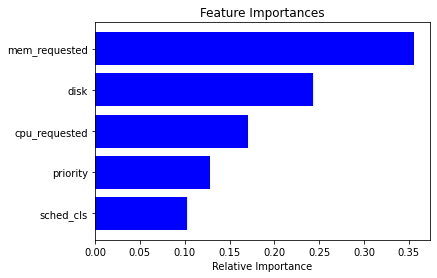

Index(['sched_cls', 'priority', 'cpu_requested', 'mem_requested', 'disk'], dtype='object')

In [9]:
feature_names = X_test.columns
plot_feature_importances(model.feature_importances_, feature_names)
feature_names

Memory and Disk are the most determining factors in producing a failure

# Hyperparameter tuning
You have three possibility:
* Manual tuning: 
  * Divide the training set in training subset and validation subset
  * Train different classifiers (with different hyperparameters) on the training subset
  * Check their performance, i.e., accuracy, on the validation subset
  * Choose the best
  * Test it on the test set
* `GridSearchCV` (as in `02.regression/b.polynomial-regression.ipynb`)
* `RandomizedSearchCV`

We use the latter now. See [Open Data Science post](https://medium.com/@ODSC/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn-d60b7aa07ead).

Let's first define the values of the parameters we want to explore

In [14]:
parameter_grid = {
    'max_features':[1,2,3,4,5],
    'max_leaf_nodes':[16, 32, 64]
}

time: 1.27 ms


In [15]:
# Note that we use 1 CPU per classifier, since we are training different 
# classifiers
forest = RandomForestClassifier(n_estimators=200, random_state = 4, n_jobs=1)


search = RandomizedSearchCV(estimator=forest, param_distributions=param_grid,
                            n_iter=50, verbose=2,random_state=42, n_jobs=-1,
                         
                         SPLITTTT
                         
                          )

TypeError: ignored

time: 109 ms


# References

[He16] Hemmat, R. A., & Hafid, A. (2016). SLA Violation Prediction In Cloud Computing: A Machine Learning Perspective. Retrieved from http://arxiv.org/abs/1611.10338

[Re11] Reiss, C., Wilkes, J., & Hellerstein, J. (2011). Google cluster-usage traces: format+ schema. Google Inc., …, 1–14. https://doi.org/10.1007/978-3-540-69057-3_88